In [1]:
%matplotlib inline
import math
import decimal
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from functools import lru_cache
from IPython.display import HTML

In [2]:
f = lambda x,y:30*y*(x-0.2)*(x-0.7) # y'
dfdx = lambda x,y: 30*(x**2 - 0.9*x + 0.14) * f(x,y) + 60*(x - 0.45)*y  # y''
d2fdx2 = lambda x,y: 30*(x**2 - 0.9*x + 0.14) *dfdx(x,y) + 120*(x - 0.45)*f(x,y) + 60*y #y'''



In [3]:
# Эталон

def etalon():
    h = 1 / 1000
    x = 0
    
    points = []
    while x < 1: 
        y = 0.1 * math.e **(x*(4.2 - 13.5*x + 10* x**2))
        points.append((x, y))
        x += h
    return points

In [4]:
# Явный метод эйлера
@lru_cache()
def explicit_euler(n=10):
    h = 1 / n
    points = [(0, 0.1)]
    while points[-1][0] < 1: 
        x, y = points[-1]

        x_new = x + h
        y_new = y + h * f(x, y)
        points.append((x_new, y_new))
    return points

In [5]:
# Метод эйлера с пересчётом
@lru_cache()
def euler_method_with_recount(n=10):
    h = 1 / n
    points = [(0, 0.1)]
    while points[-1][0] < 1: 
        x, y = points[-1]
        
        y_temp = y + h * f(x, y)
        
        x_new = x + h
        y_new = y + h/2 * (f(x, y) + f(x_new, y_temp))
        
        points.append((x_new, y_new))
    return points

In [6]:
# Метод коши
@lru_cache()
def cauchy(n=10):
    h = 1 / n
    points = [(0, 0.1)]
    while points[-1][0] < 1: 
        x, y = points[-1]
        
        y_temp = y + h/2 * f(x, y)
        
        x_new = x + h
        y_new = y + h * f(x + h/2, y_temp)
        
        points.append((x_new, y_new))
    return points

In [7]:
# Метод Рунге-Кута 4-го порядка
@lru_cache()
def runge_kutta_method(n=10):
    h = 1 / n
    points = [(0, 0.1)]
    while points[-1][0] < 1: 
        x, y = points[-1]
        
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        x_new = x + h
        y_new = y + 1/6 * (k1 + 2*k2 + 2*k3 + k4)
        
        points.append((x_new, y_new))
    return points

In [8]:
# Неявный метод Эйлера
@lru_cache()
def nonexplicit_euler(n=10):
    h = 1 / n
    points = [(0, 0.1)]
    while points[-1][0] < 1: 
        x, y = points[-1]

        x_new = x + h
        y_new = y / (1 - 30*h*(x_new-0.2)*(x_new-0.7))
        points.append((x_new, y_new))
    return points

In [9]:
# Тейлор 2-го порядка
@lru_cache()
def taylor2(n=10):
    h = 1 / n
    points = [(0, 0.1)]
    while points[-1][0] < 1: 
        x, y = points[-1]

        x_new = x + h
        y_new = y + h*f(x,y) + h*h/2 * dfdx(x,y)
        points.append((x_new, y_new))
    return points

In [10]:
# Тейлор 3-го порядка
@lru_cache()
def taylor3(n=10):
    h = 1 / n
    points = [(0, 0.1)]
    while points[-1][0] < 1: 
        x, y = points[-1]

        x_new = x + h
        y_new = y + h*f(x,y) + h*h/2 * dfdx(x,y) + h*h*h/6 * d2fdx2(x, y)
        points.append((x_new, y_new))
    return points

In [11]:
# Адамс 2 шага
@lru_cache()
def adams2(n=10):
    h = 1 / n
    points = [(0, 0.1)]
    while points[-1][0] < 1: 
        x, y = points[-1]

        x_new = x + h
        y_new = (y + 15*h*y*(x-0.2)*(x-0.7)) / (1 - 15*h*(x_new - 0.2)*(x_new - 0.7))
        points.append((x_new, y_new))
    return points

In [24]:
# Адамс 3 шага
@lru_cache()
def adams3(n=10):
    h = 1 / n
    points = [(0, 0.1)]
    
    # посчитаем еще одну точку по коши
    x, y = points[-1]  
    y_temp = y + h/2 * f(x, y)
    x_new = x + h
    y_new = y + h * f(x + h/2, y_temp)
    points.append((x_new, y_new))
    
    while points[-1][0] < 1: 
        x_old, y_old = points[-2]
        x, y = points[-1]

        x_new = x + h
        y_new = (y + h/12*(8*f(x,y) - f(x_old, y_old))) / (1 - 30*5*h/12 * (x_new - 0.2)*(x_new - 0.7))
        points.append((x_new, y_new))
    return points

In [13]:
def make_ani(func, name):
    fig, ax = plt.subplots()
    fig.suptitle(name, fontsize=16)
    ax.axis([0, 1,0.05,0.2])
    lines = [ax.plot([], [], 'r-')[0], ax.plot([], [], 'bo-')[0]]

    x_et, y_et = zip(*etalon())
    lines[0].set_data(x_et, y_et)

    ns = [5,10,15,20,30,50,100,1000]
    def animate(i):
        x, y = zip(*func(ns[i]))

        lines[1].set_label('n' + name+ ' = ' + str(ns[i]))
        legend = plt.legend(loc='upper left')
        lines[1].set_data(x, y)

    return animation.FuncAnimation(fig, animate, frames=len(ns), interval=500)


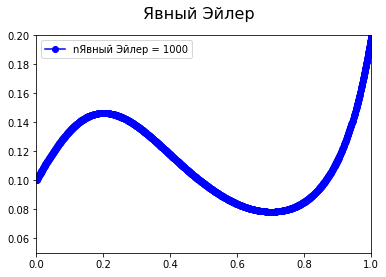

In [14]:
HTML(make_ani(explicit_euler, 'Явный Эйлер').to_jshtml())


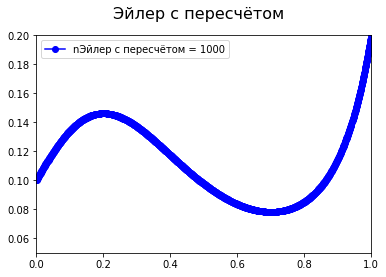

In [15]:
HTML(make_ani(euler_method_with_recount, 'Эйлер с пересчётом').to_jshtml())

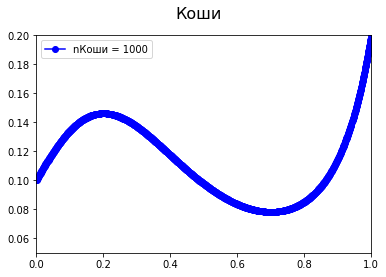

In [16]:
HTML(make_ani(cauchy, 'Коши').to_jshtml())

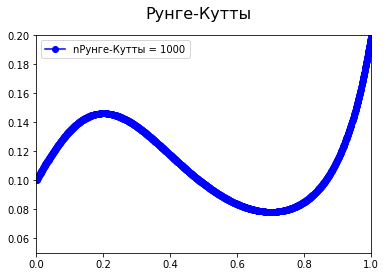

In [17]:
HTML(make_ani(runge_kutta_method, 'Рунге-Кутты').to_jshtml())

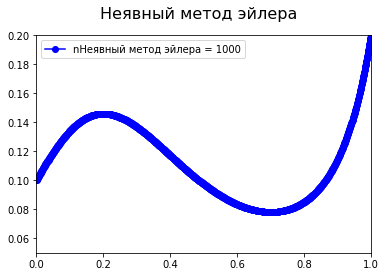

In [18]:
HTML(make_ani(nonexplicit_euler, 'Неявный метод эйлера').to_jshtml())

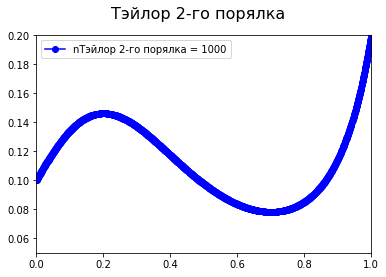

In [19]:
HTML(make_ani(taylor2, 'Тэйлор 2-го порялка').to_jshtml())

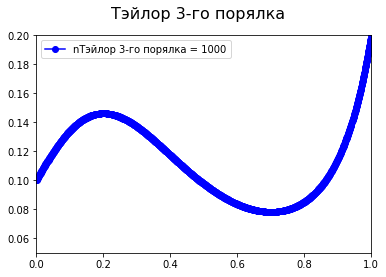

In [20]:
HTML(make_ani(taylor3, 'Тэйлор 3-го порялка').to_jshtml())

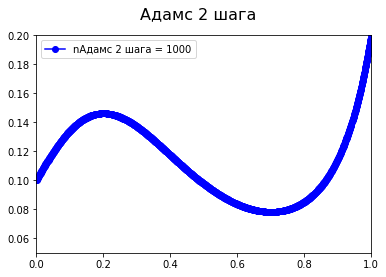

In [21]:
HTML(make_ani(adams2, 'Адамс 2 шага').to_jshtml())

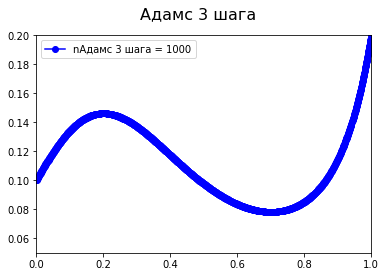

In [25]:
HTML(make_ani(adams3, 'Адамс 3 шага').to_jshtml())